In [1]:
!nvidia-smi

Sun Oct 27 07:46:48 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    30W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!sudo pip3 install contractions
!sudo pip3 install textsearch
!sudo pip3 install tqdm
!sudo pip3 install nltk
!sudo pip3 install beautifulsoup4
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
import tensorflow as tf
tf.__version__

'2.0.0'

In [4]:
tf.test.is_gpu_available()

True

In [5]:
import pandas as pd
import numpy as np

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [6]:
dataset = pd.read_csv(r'https://github.com/dipanjanS/nlp_workshop_dhs18/raw/master/Unit%2011%20-%20Sentiment%20Analysis%20-%20Unsupervised%20Learning/movie_reviews.csv.bz2', compression='bz2')
dataset['sentiment'] = [1 if record == 'positive' else 0 for record in dataset['sentiment']]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
review       50000 non-null object
sentiment    50000 non-null int64
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [7]:
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [8]:
reviews = dataset['review'].values
sentiments = dataset['sentiment'].values

train_reviews = reviews[:5000]
val_reviews = reviews [5000:10000]
test_reviews = reviews[10000:]



train_sentiments = sentiments[:5000]
val_sentiments = sentiments [5000:10000]
test_sentiments = sentiments[10000:]

train_reviews.shape, val_reviews.shape, test_reviews.shape

((5000,), (5000,), (40000,))

In [9]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def pre_process_corpus(docs):
    norm_docs = []
    for doc in tqdm.tqdm(docs):
        doc = strip_html_tags(doc)
        doc = doc.translate(doc.maketrans("\n\t\r", "   "))
        doc = doc.lower()
        doc = remove_accented_chars(doc)
        doc = contractions.fix(doc)
        # lower case and remove special characters\whitespaces
        doc = re.sub(r'[^a-zA-Z0-9\s]', ' ', doc, re.I|re.A)
        doc = re.sub(' +', ' ', doc)
        doc = doc.strip()  
        norm_docs.append(doc)
    return norm_docs

In [10]:
%%time

norm_train_texts = pre_process_corpus(train_reviews)
norm_val_texts = pre_process_corpus(val_reviews)
norm_test_texts = pre_process_corpus(test_reviews)

100%|██████████| 40000/40000 [00:19<00:00, 2081.67it/s]

CPU times: user 23.9 s, sys: 232 ms, total: 24.1 s
Wall time: 24 s


In [11]:
t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_texts)
t.word_index['<PAD>'] = 0

In [12]:
print(max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), 
      min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), 
      t.word_index['<UNK>'])

('unscarred', 39231) ('<PAD>', 0) 1


In [13]:
train_sequences = t.texts_to_sequences(norm_train_texts)
val_sequences = t.texts_to_sequences(norm_val_texts)
test_sequences = t.texts_to_sequences(norm_test_texts)

In [14]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=39232
Number of Documents=5000


(0, 2000)

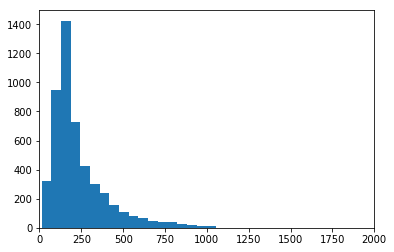

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist([len(doc.split()) for doc in norm_train_texts], bins=30);
plt.xlim([0, 2000])

In [16]:
MAX_SEQUENCE_LENGTH = 500

# pad dataset to a maximum review length in words
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_val = tf.keras.preprocessing.sequence.pad_sequences(val_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((5000, 500), (40000, 500))

In [17]:
VOCAB_SIZE = len(t.word_index)
EMBED_SIZE = 300
EPOCHS=100
BATCH_SIZE=128

In [18]:
# define our attention layer for later
class AttentionLayer(tf.keras.layers.Layer):

    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        """

        self.supports_masking = True
        self.init = tf.keras.initializers.get('glorot_uniform')

        self.W_regularizer = tf.keras.regularizers.get(W_regularizer)
        self.b_regularizer = tf.keras.regularizers.get(b_regularizer)

        self.W_constraint = tf.keras.constraints.get(W_constraint)
        self.b_constraint = tf.keras.constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]
        
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = tf.keras.backend.reshape(tf.keras.backend.dot(tf.keras.backend.reshape(x, 
                                                                                     (-1, features_dim)),
                                                            tf.keras.backend.reshape(self.W, 
                                                                                     (features_dim, 1))),
                                        (-1, step_dim))
        
        if self.bias:
            eij += self.b

        eij = tf.keras.backend.tanh(eij)

        a = tf.keras.backend.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= tf.keras.backend.cast(mask, tf.keras.backend.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        a /= tf.keras.backend.cast(tf.keras.backend.sum(a, axis=1, keepdims=True) + tf.keras.backend.epsilon(), 
                                                                                    tf.keras.backend.floatx())
        a = tf.keras.backend.expand_dims(a)
        weighted_input = x * a
        
        return tf.keras.backend.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim

    def get_config(self):
        config = {'step_dim': self.step_dim}
        base_config = super(AttentionLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [19]:
word2idx = t.word_index
FASTTEXT_INIT_EMBEDDINGS_FILE = './wiki-news-300d-1M-subword.vec'


def load_pretrained_embeddings(word_to_index, max_features, embedding_size, embedding_file_path):    
    
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    embeddings_index = dict(get_coefs(*row.split(" ")) 
                                for row in open(embedding_file_path, encoding="utf8", errors='ignore') 
                                    if len(row)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean, emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_to_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_size))
    
    for word, idx in word_to_index.items():
        if idx >= max_features: 
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [20]:
ft_embeddings = load_pretrained_embeddings(word_to_index=word2idx, 
                                           max_features=VOCAB_SIZE, 
                                           embedding_size=EMBED_SIZE, 
                                           embedding_file_path=FASTTEXT_INIT_EMBEDDINGS_FILE)
ft_embeddings.shape

(39232, 300)

In [25]:
inp = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH, ))
embed = tf.keras.layers.Embedding(VOCAB_SIZE, 
                                  EMBED_SIZE, 
                                  weights=[ft_embeddings],
                                  trainable=True)(inp)
bigru = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=256, return_sequences=True))(embed)
attn = AttentionLayer(MAX_SEQUENCE_LENGTH)(bigru)
dense1 = tf.keras.layers.Dense(256, activation='relu')(attn)
drop1 = tf.keras.layers.Dropout(0.25)(dense1)
dense2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(0.25)(dense2)
outp = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.models.Model(inputs=inp, outputs=outp)
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 300)          11769600  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 500, 512)          1140736   
_________________________________________________________________
attention_layer_1 (Attention (None, 512)               1012      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               6579

In [26]:
# Fit the model
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=3,
                                      restore_best_weights=True,
                                      verbose=1)

model.fit(X_train, train_sentiments, 
          validation_data=(X_val, val_sentiments),
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          shuffle=True,
          callbacks=[es],
          verbose=1)

Train on 5000 samples, validate on 5000 samples
Epoch 1/100
5000/5000 [==============================] - 22s 4ms/sample - loss: 0.6897 - accuracy: 0.5374 - val_loss: 0.6737 - val_accuracy: 0.5184
Epoch 2/100
5000/5000 [==============================] - 18s 4ms/sample - loss: 0.5334 - accuracy: 0.7374 - val_loss: 0.3528 - val_accuracy: 0.8486
Epoch 3/100
5000/5000 [==============================] - 18s 4ms/sample - loss: 0.1841 - accuracy: 0.9344 - val_loss: 0.3331 - val_accuracy: 0.8708
Epoch 4/100
5000/5000 [==============================] - 18s 4ms/sample - loss: 0.0556 - accuracy: 0.9814 - val_loss: 0.4700 - val_accuracy: 0.8590
Epoch 5/100
5000/5000 [==============================] - 18s 4ms/sample - loss: 0.0170 - accuracy: 0.9952 - val_loss: 0.5902 - val_accuracy: 0.8546
Epoch 6/100
5000/5000 [==============================] - 18s 4ms/sample - loss: 0.0056 - accuracy: 0.9986 - val_loss: 0.6845 - val_accuracy: 0.8668
Epoch 00006: early stopping


In [27]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

predictions = [1 if pr > 0.5 else 0 
                   for pr in model.predict(X_test, batch_size=512, verbose=0).ravel()]

print("Accuracy: %.2f%%" % (accuracy_score(test_sentiments, predictions)*100))
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions))

Accuracy: 86.43%
             precision    recall  f1-score   support

          0       0.84      0.91      0.87     20028
          1       0.90      0.82      0.86     19972

avg / total       0.87      0.86      0.86     40000



,0,1
0,18189,1839
1,3588,16384
